In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")
#print(path)

c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
#print("Files in dataset:", FILES)



In [4]:
from nlprocess import load_data2dataframe

dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [5]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [6]:
from nlprocess import normalize_spacy
from nlprocess import to_corpus
import spacy
nlp = spacy.load("en_core_web_sm") 
Dict = to_corpus(df, "stressor_word", "bow" , nlp = nlp)

Building BOW Corpus: 100%|██████████| 3885/3885 [00:00<00:00, 993165.79it/s]


計算最佳主題數 4群 泛化能力稍佳
---

In [8]:
ddf , texts ,dictionary ,corpus = Dict["df"], Dict["texts"], Dict["dictionary"], Dict["corpus"]

In [9]:
from find_best_number_of_topic import score_coherence
avg_values = score_coherence(dictionary , corpus, texts, "c_v", start=2, limit=10, num_runs=5, alpha='auto', eta='auto', passes=10)

Running coherence scores: 100%|██████████| 5/5 [05:31<00:00, 66.40s/it]


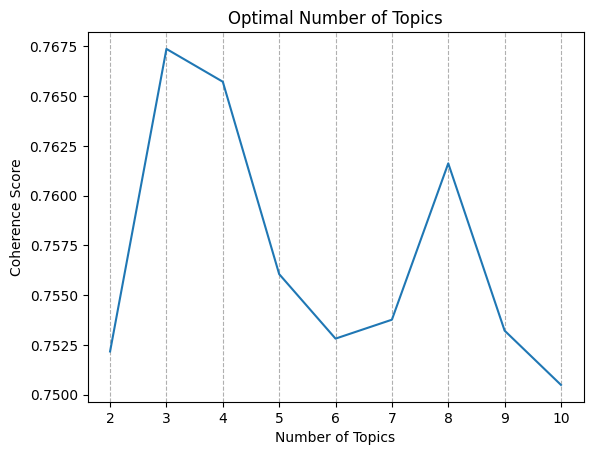

In [12]:

x = range(2,11)
plt.plot(x, np.mean(avg_values , axis=0))
plt.title("Optimal Number of Topics")
plt.grid(axis="x" , linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

模型建立-進行主題分群
---

load model
---

In [ ]:
# 讀取模型
from gensim.models import LdaModel
lda_model = LdaModel.load("LDA/topics_4_best_model.model")
# 取得每筆資料的主題分佈
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# 取最大主題編號作為群標籤
topic_labels = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

FileNotFoundError: [Errno 2] No such file or directory: 'lda_model_4topics_best_model.model'

In [ ]:
ddf["topic"] = topic_labels
ddf.head(10)

,text,stressor_class,stressor_word,interval,normalized,topic
0,Why are there always trivial matters in life t...,T1,financial,8,[financial],0
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,"[urge, marry]",1
2,"In the coming March, my work pressure will be ...",T1,work,8,[work],2
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,[paper],0
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,[learn],1
5,Staying up late is irreparable damage. I've st...,T1,learn,8,[learn],1
6,Watching decompressing videos on Douyin increa...,T1,decompressing videos,8,"[decompress, video]",1
7,The pressure from scrolling through Xiaohongsh...,T1,Xiaohongshu,8,[xiaohongshu],1
8,I'm out of money... the baby clothing store is...,T1,baby clothing store,8,"[baby, clothing, store]",2
10,All the pressure and obstacles are given by my...,T1,my family,8,[family],2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = ddf["text"]
y = ddf["topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , stratify=y)


In [64]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
texts = [normalize_spacy(word) for word in X]
dictionary = Dictionary(texts)

X_train_tokens = [normalize_spacy(text) for text in X_train]
X_test_tokens = [normalize_spacy(text) for text in X_test]

X_train_vectorized = [dictionary.doc2bow(text) for text in X_train_tokens]
X_test_vectorized = [dictionary.doc2bow(text) for text in X_test_tokens]


tfidf_model = TfidfModel(X_train_vectorized)
X_train_tfidf = [tfidf_model[doc] for doc in X_train_vectorized]
X_test_tfidf = [tfidf_model[doc] for doc in X_test_vectorized]


In [66]:
from gensim import matutils
import numpy as np

# 將稀疏向量轉成稠密矩陣
def bow_to_dense(corpus, dictionary):
    return np.array([
        matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0]
        for bow in corpus
    ])

X_train_vectorized = bow_to_dense(X_train_tfidf, dictionary)
X_test_vectorized = bow_to_dense(X_test_tfidf, dictionary)


# 模型比對


linear-SVC
---

In [28]:
from sklearn.svm import LinearSVC
SVC_model = LinearSVC(
                        penalty="l1" ,
                        class_weight="balanced",
                        random_state=42
                    )
SVC_model.fit(X_train_vectorized, y_train)  
y_pred = SVC_model.predict(X_test_vectorized)  
print(SVC_model.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7555555555555555
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       150
           1       0.78      0.76      0.77       152
           2       0.62      0.70      0.66       138
           3       0.83      0.84      0.84       280

    accuracy                           0.76       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.76      0.76      0.76       720



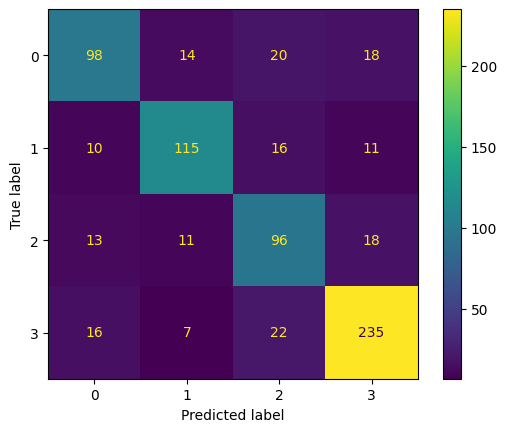

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SVC_model, X_test_vectorized, y_test)
plt.show()

LogisticRegression
---

In [423]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
LR.fit(X_train_vectorized, y_train)  
y_pred = LR.predict(X_test_vectorized)  
print(LR.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7125
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       161
           1       0.59      0.59      0.59       124
           2       0.79      0.79      0.79       290
           3       0.70      0.70      0.70       145

    accuracy                           0.71       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



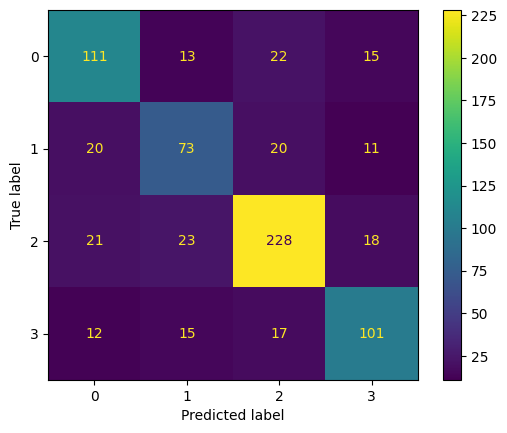

In [424]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [425]:
from sklearn.linear_model import SGDClassifier 
SGD = SGDClassifier(
                    penalty="elasticnet", 
                    class_weight="balanced",
                    random_state=42 
                )
SGD.fit(X_train_vectorized, y_train)  
y_pred = SGD.predict(X_test_vectorized)  
print(SGD.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6930555555555555
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       161
           1       0.66      0.48      0.55       124
           2       0.79      0.77      0.78       290
           3       0.66      0.64      0.65       145

    accuracy                           0.69       720
   macro avg       0.68      0.66      0.66       720
weighted avg       0.70      0.69      0.69       720



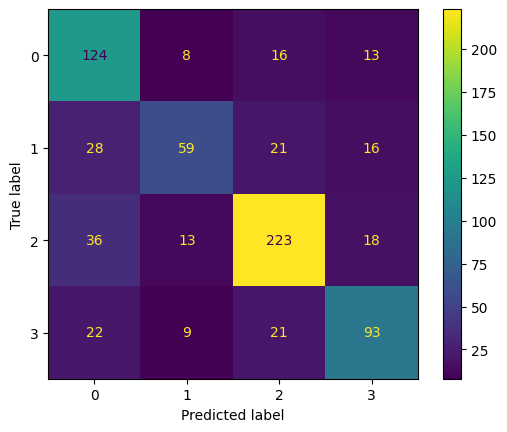

In [426]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SGD, X_test_vectorized, y_test)
plt.show()

交叉驗證-1
---

In [427]:
from sklearn.model_selection import cross_val_score

print("LR : " , cross_val_score(LR, X_test_vectorized, y_test, cv=5).mean())
print("SVC : ",cross_val_score(SVC_model, X_test_vectorized, y_test, cv=5).mean())
print("SGD : ",cross_val_score(SGD, X_test_vectorized, y_test, cv=5).mean())

LR :  0.5694444444444444
SVC :  0.6069444444444445
SGD :  0.5638888888888889


# 超參數搜尋

linear-svc
---

In [429]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1e-2 , 0.1 , 1 ,2 ,3],
    'tol': [1e-4, 1e-3]
}

svc_model = LinearSVC(random_state=42 , class_weight="balanced")
grid_svc = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_vectorized, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_params_)

0.715625
{'C': 1, 'penalty': 'l1', 'tol': 0.0001}


In [430]:
print(classification_report(y_test, grid_svc.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       161
           1       0.65      0.60      0.63       124
           2       0.80      0.79      0.79       290
           3       0.70      0.72      0.71       145

    accuracy                           0.72       720
   macro avg       0.71      0.70      0.71       720
weighted avg       0.72      0.72      0.72       720



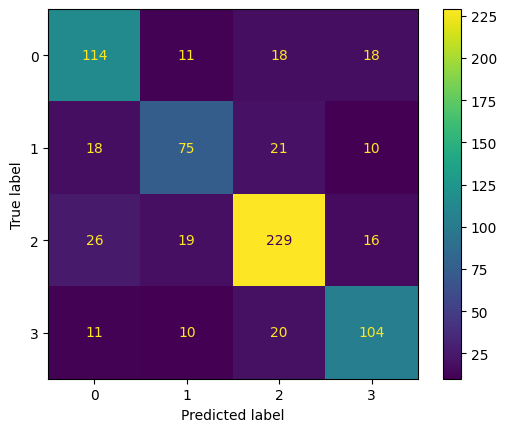

In [431]:
ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, X_test_vectorized, y_test)
plt.show()

logistic-regression
---

In [443]:
from sklearn.linear_model import LogisticRegression 

lr_param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'tol': [1e-3, 1e-4],
    'l1_ratio': [0.5, 0.7, 0.9, 1.0]
}

lr_model = LogisticRegression(
                              penalty='l1',
                              class_weight='balanced',
                              solver='liblinear',
                              max_iter=1000,
                              random_state=42
                            )
grid_lr = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vectorized, y_train)

print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.7
{'C': 1, 'l1_ratio': 0.5, 'tol': 0.001}


c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [444]:
print(classification_report(y_test, grid_lr.predict(X_test_vectorized)))


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       161
           1       0.55      0.60      0.58       124
           2       0.82      0.77      0.80       290
           3       0.68      0.70      0.69       145

    accuracy                           0.71       720
   macro avg       0.68      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



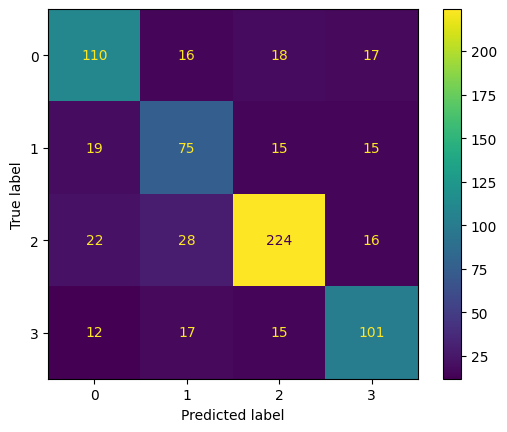

In [434]:
ConfusionMatrixDisplay.from_estimator(grid_lr.best_estimator_, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [446]:
from sklearn.linear_model import SGDClassifier

sgd_param_grid = {
    'penalty': ['elasticnet'],
    'alpha': [1e-4, 5e-4, 1e-3],
    'l1_ratio': [0.7, 0.9, 1.0],
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'epsilon': [0.1],
    'tol' : [1e-3, 1e-2]
}


sgd_model = SGDClassifier(random_state=42)
grid_sgd = GridSearchCV(sgd_model, sgd_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_sgd.fit(X_train_vectorized, y_train)

print(grid_sgd.best_score_)
print(grid_sgd.best_params_)

0.7149305555555556
{'alpha': 0.0005, 'class_weight': 'balanced', 'epsilon': 0.1, 'l1_ratio': 0.7, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.001}


In [436]:
print(classification_report(y_test, grid_sgd.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       161
           1       0.69      0.51      0.59       124
           2       0.81      0.77      0.79       290
           3       0.65      0.72      0.68       145

    accuracy                           0.70       720
   macro avg       0.69      0.68      0.68       720
weighted avg       0.71      0.70      0.70       720



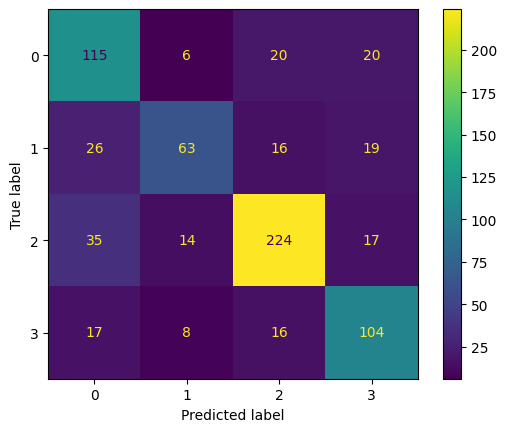

In [437]:
ConfusionMatrixDisplay.from_estimator(grid_sgd.best_estimator_, X_test_vectorized, y_test)
plt.show()

交叉驗證-2
---

In [447]:
models = [
            grid_svc.best_estimator_, 
            grid_lr.best_estimator_, 
            grid_sgd.best_estimator_,
        ]
for model in models:
    print(cross_val_score(model, X_train_vectorized, y_train, cv=5).mean())

0.715625


c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l

0.7
0.7149305555555556


predicted_topic

In [1]:
# 使用所有模型對 X_test_vectorized 進行預測並顯示準確率
from sklearn.metrics import accuracy_score
for model in models:
    y_pred = model.predict(X_test_vectorized)
    print(f"{model.__class__.__name__} accuracy: {accuracy_score( y_test,y_pred )}")

NameError: name 'models' is not defined

In [449]:
import joblib

# 存儲最佳模型
joblib.dump(grid_svc.best_estimator_, "best_linear_svc_model.joblib")
joblib.dump(grid_lr.best_estimator_, "best_logistic_regression_model.joblib")
joblib.dump(grid_sgd.best_estimator_, "best_sgd_classifier_model.joblib")

['best_sgd_classifier_model.joblib']